# Import

In [221]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [222]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [223]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_1_layout import layout
from util import *

## Set condition

In [224]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [277]:
data_types = ["AgNewsTitle"]
vectorize_type = "doc2vec"

In [278]:
model_nums = config["clustering"]["gmm"]["max_model_num"]
covariance_type = "spherical"
normalizations = ["normalized", "centralized"]
vector_dims = [2, 4, 6, 8, 10, 20, 40, 80, 160]

In [279]:
stats_vals = ["aic", "bic", "mi", "logl"]

# Stats

## Read data

In [280]:
# データ型定義
stats = {
    stats_val: {
        normalization: {model_num: pd.DataFrame for model_num in range(model_nums)}
        for normalization in normalizations
    }
    for stats_val in stats_vals
}

# データ取得
for data_type in data_types:
    for stats_val in stats_vals:
        for model_num in range(model_nums):
            for normalization in normalizations:
                stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{covariance_type}/{model_num}.csv"
                df = pd.read_csv(stats_path, index_col=0)
                stats[stats_val][normalization][model_num] = df.loc[:, stats_val]

In [9]:
def load_lda_mi(data_type):
    lda_mi = pd.read_csv(
        f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0
    )
    describe_lda_mi, _ = get_describe(lda_mi, axis=0)
    return describe_lda_mi

In [281]:
stats = {
    stats_val: {
        normalization: pd.concat(stats[stats_val][normalization], axis=1)
        for normalization in normalizations
    }
    for stats_val in stats_vals
}

## Data shaping

In [282]:
stats_describe = {stats_val: {} for stats_val in stats_vals}
for stats_val in stats_vals:
    for normalization in normalizations:
        stats_describe[stats_val][normalization], describe_key = get_describe(
            stats[stats_val][normalization], axis=1
        )

# Coherence

## Read Data

In [283]:
coherences = {normalization: {} for normalization in normalizations}
for normalization in normalizations:
    for vector_dim in vector_dims:
        coherence_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/coherence/{normalization}/{vector_dim}.csv"
        coherence = pd.read_csv(coherence_path, index_col=0)
        coherences[normalization][vector_dim] = coherence.loc[:, covariance_type]

In [284]:
coherences = {
    normalization: pd.concat(coherences[normalization], axis=1)
    for normalization in normalizations
}

## Data shaping

In [285]:
coherences_describe, coherences_describe_key = get_describe(coherences[normalization])

# Make Chart

In [286]:
xlabel = "埋め込み次元"
ylabel = {
    "mi": "AMI",
    "aic":"AIC",
    "bic": "BIC",
    "logl": "log likelihood"
}
yticks = {"AMI": np.arange(0, 0.7, 0.1)}
loc = {
    "aic": "lower left",
    "bic": "lower left",
    "mi": "upper right",
    "logl": "upper left",
}
title = {"20News": "A", "AgNews": "B", "AgNewsTitle": "C"}

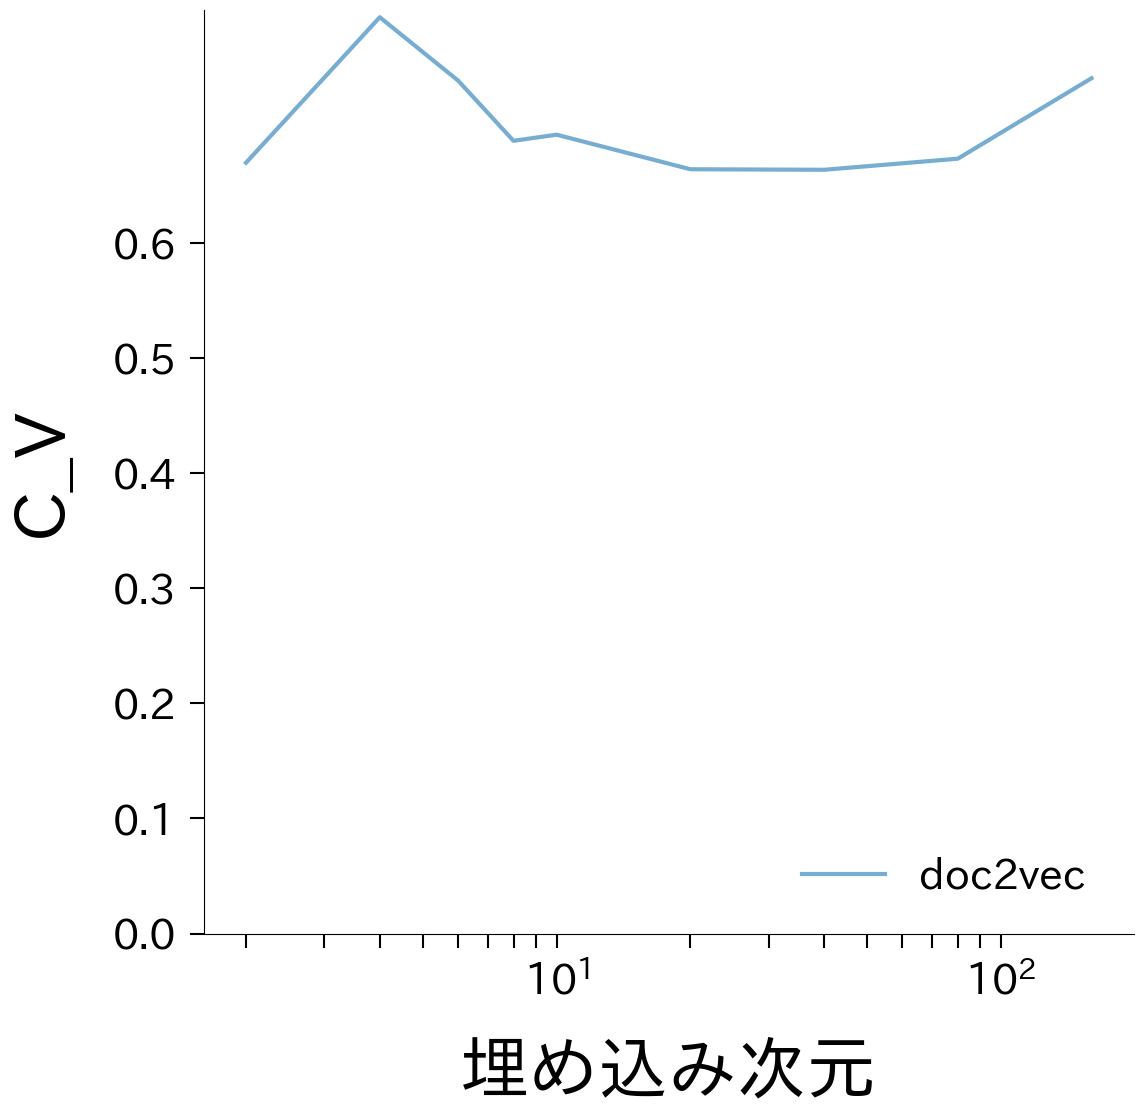

In [287]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
# fig_path = f"../data/figure/{data_type}/StatsCovariance{data_type}.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.plot(
    coherences_describe["mean"],
    label=f"doc2vec ",
    **layout["plot"],
)


ax.tick_params(which="both", width=1.5, length=8, size=10, direction="out")
ax.xaxis.set_tick_params(labelsize=30, pad=10)
ax.yaxis.set_tick_params(labelsize=30, pad=10)

ax.set_xlabel(xlabel, fontsize=50, labelpad=27, fontweight="black")
ax.set_ylabel("C_V", fontsize=50, labelpad=27, fontweight="black")
ax.set_yticks(np.arange(0, 0.7, 0.1))
ax.legend(fontsize=30, framealpha=0, loc="lower right")

# fig.savefig(make_filepath(fig_path))

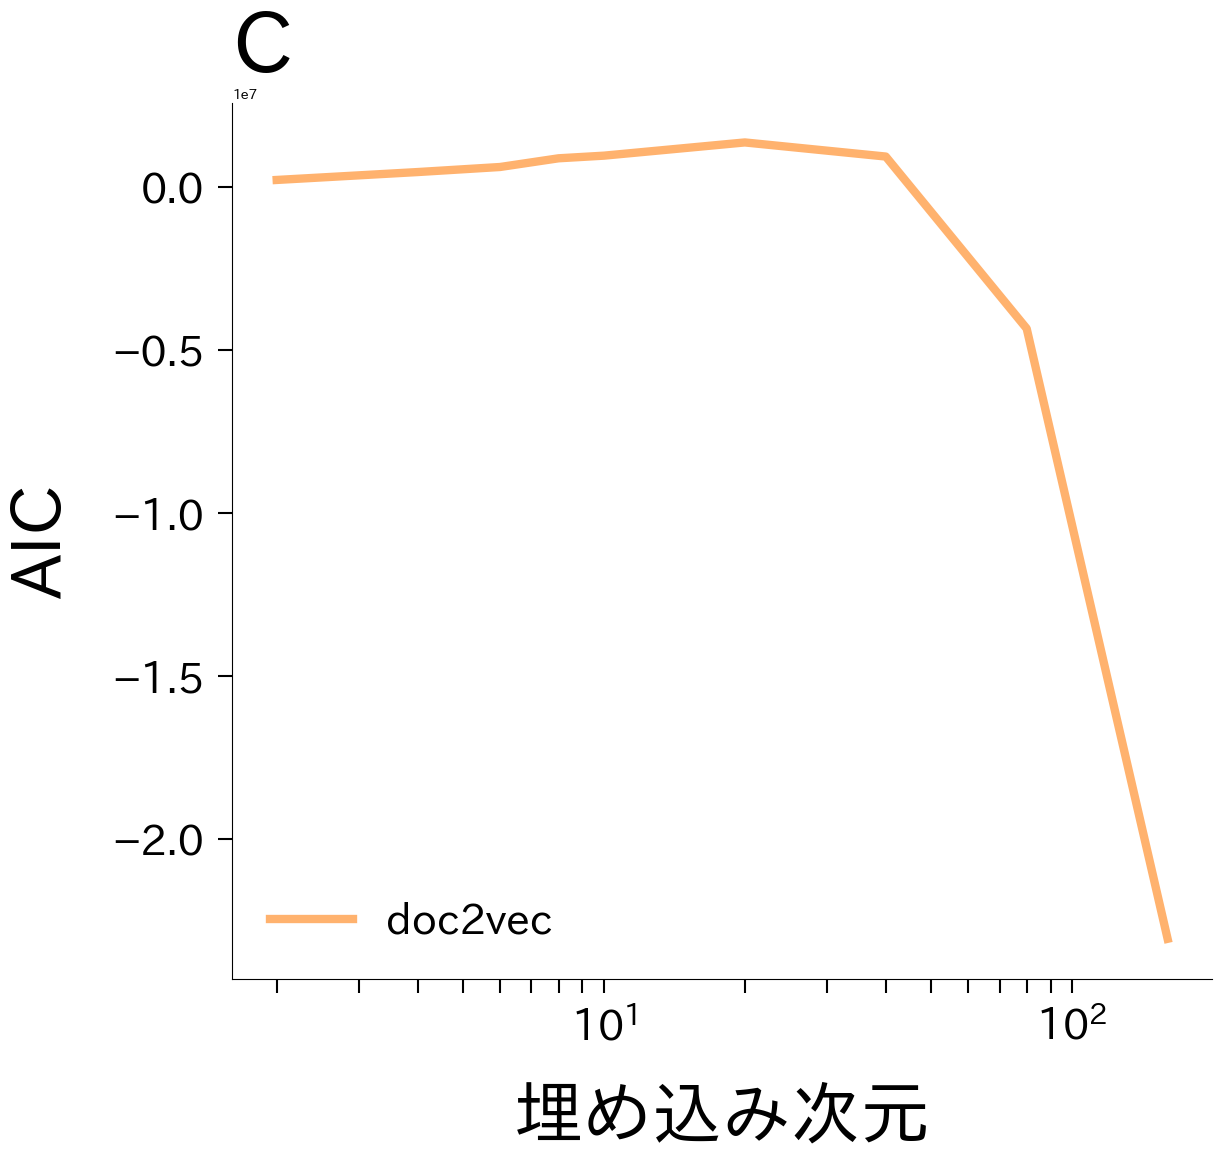

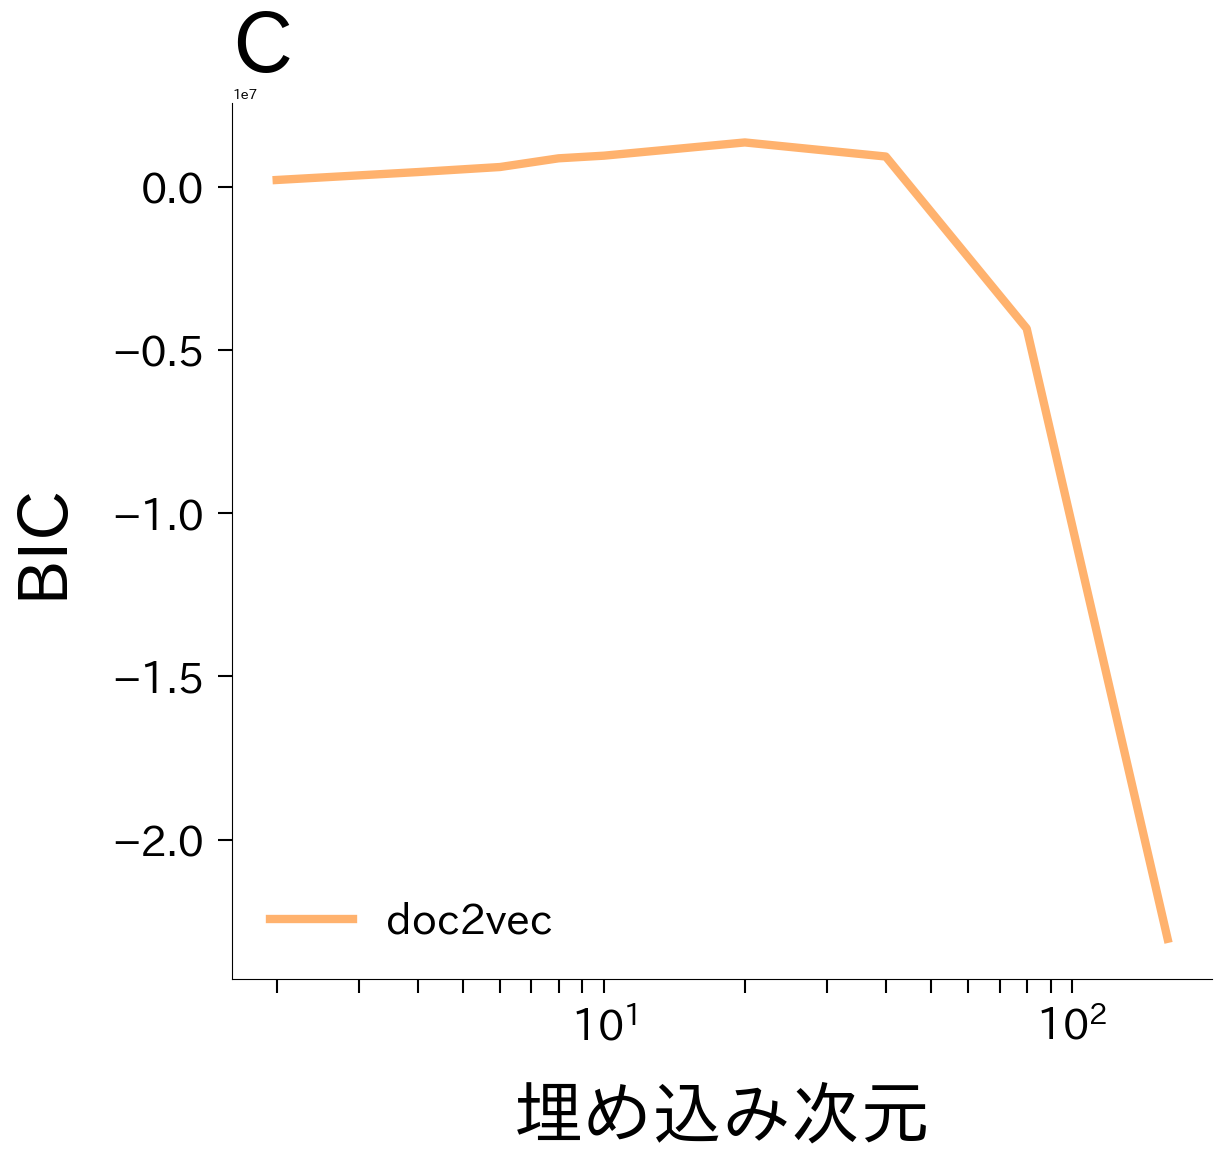

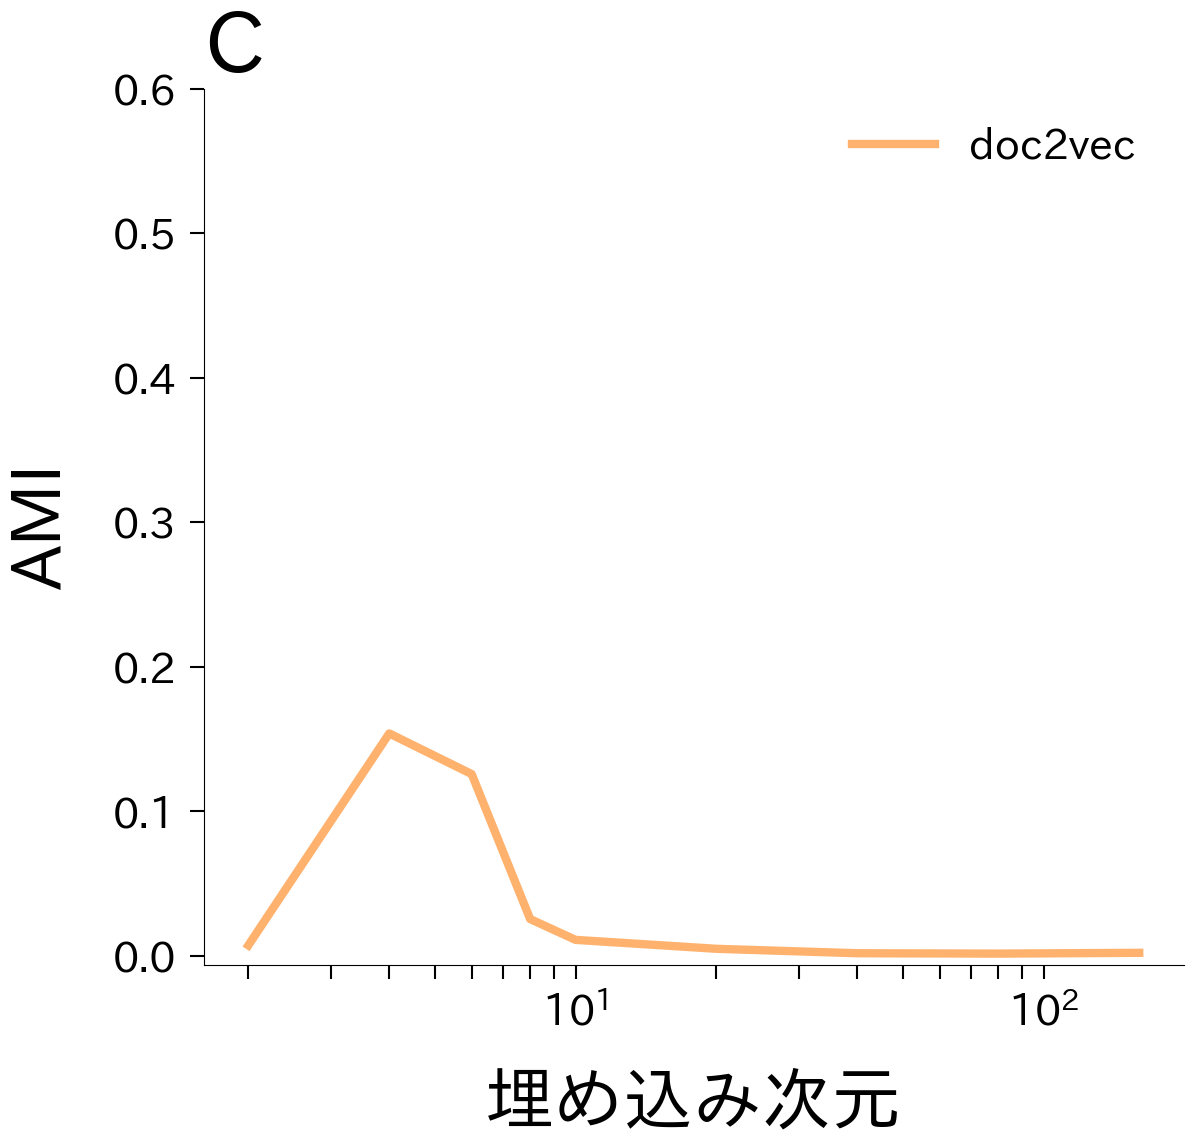

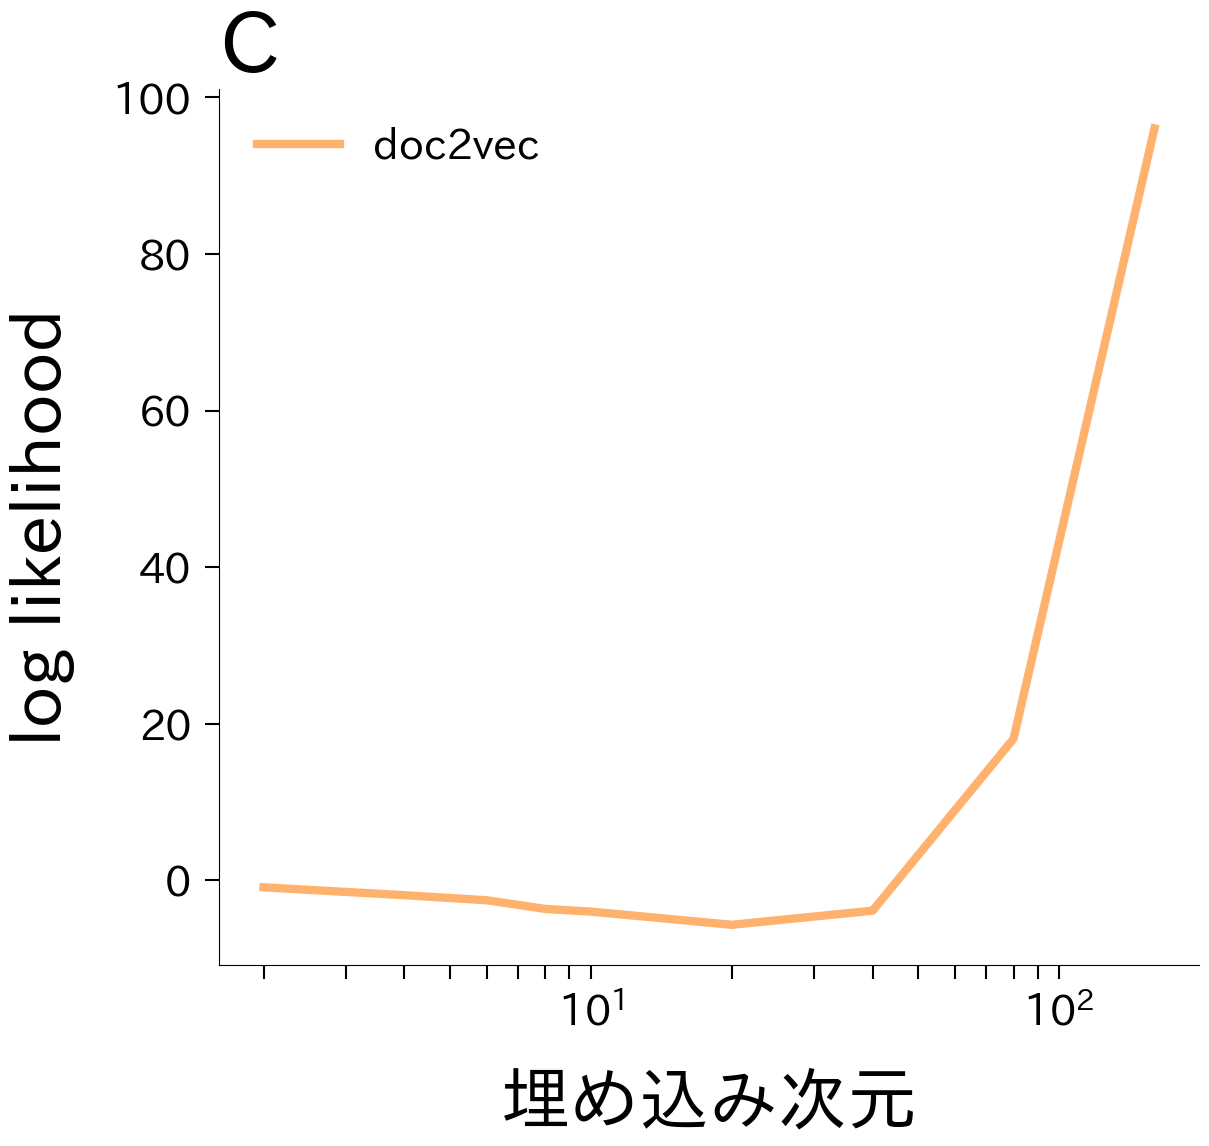

In [291]:
for stat in stats:
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.2, bottom=0.15)
    fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats_{data_type}_{vectorize_type}_{stat}.pdf"
    ax.set_xscale("log")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.plot(
        stats_describe[stat]["centralized"]["mean"],
        label=f"doc2vec ",
        alpha=0.6,
        linewidth=6.0,
        color="#ff7f0e"
    )

    ax.set_title(title[data_type], fontsize=60, loc="left")

    ax.tick_params(which="both", width=1.5, length=8, size=10, direction="out")
    ax.xaxis.set_tick_params(labelsize=30, pad=10)
    ax.yaxis.set_tick_params(labelsize=30, pad=10)

    ax.set_xlabel(xlabel, fontsize=50, labelpad=27, fontweight="black")
    ax.set_ylabel(ylabel[stat], fontsize=50, labelpad=27, fontweight="black")
    if stat == "mi":
        ax.set_yticks(np.arange(0, 0.7, 0.1))
    ax.legend(fontsize=30, framealpha=0, loc=loc[stat])
    fig.savefig(make_filepath(fig_path))